## Install the dependencies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow

# Extract the crops disease dataset zip file

In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Crop_Disease.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()
print("Extract the dataset zip file successfully.")

Extract the dataset zip file successfully.


# Import the necessaries libraries

In [4]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import classification_report
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau


# Loading the dataset

In [5]:
BASE_DIRECTORY = r'/content/Crop_Disease/'
train_img_path = r'/content/Crop_Disease/train'
test_img_path = r'/content/Crop_Disease/test'
val_img_path = r'/content/Crop_Disease/val'

# Prepare the dataset

In [6]:
# Get a list of all class labels in the dataset
class_label = os.listdir(train_img_path)
print("Number of class labels found:", len(class_label))

Number of class labels found: 14


In [7]:
class_img_path = []

for class_lbl in class_label:
    # Get a list of all images in the current class
    class_img_name = os.listdir(os.path.join(train_img_path, class_lbl))

    # Add  class label and image path to list
    for img_name in class_img_name:
        img_path = os.path.join(train_img_path, class_lbl, img_name)
        class_img_path.append((class_lbl, img_path))

# Create a DataFrame from the list
df = pd.DataFrame(class_img_path, columns=['Class Label', 'Image Path'])
df

Class Label                                         Image Path
0         Corn___Healthy  /content/Crop_Disease/train/Corn___Healthy/85e...
1         Corn___Healthy  /content/Crop_Disease/train/Corn___Healthy/eea...
2         Corn___Healthy  /content/Crop_Disease/train/Corn___Healthy/60d...
3         Corn___Healthy  /content/Crop_Disease/train/Corn___Healthy/5a1...
4         Corn___Healthy  /content/Crop_Disease/train/Corn___Healthy/d51...
...                  ...                                                ...
20632  Rice___Leaf_Blast  /content/Crop_Disease/train/Rice___Leaf_Blast/...
20633  Rice___Leaf_Blast  /content/Crop_Disease/train/Rice___Leaf_Blast/...
20634  Rice___Leaf_Blast  /content/Crop_Disease/train/Rice___Leaf_Blast/...
20635  Rice___Leaf_Blast  /content/Crop_Disease/train/Rice___Leaf_Blast/...
20636  Rice___Leaf_Blast  /content/Crop_Disease/train/Rice___Leaf_Blast/...

[20637 rows x 2 columns]

In [8]:
# Let's check how many img for each class are present
print("Total number of images in the dataset: ", len(df))

label_count = df['Class Label'].value_counts()
print(label_count)

Total number of images in the dataset:  20637
Class Label
Corn___Leaf_Blight       2671
Corn___Common_Rust       2669
Corn___Healthy           2602
Corn___Gray_Leaf_Spot    2298
Potato___Early_Blight    2204
Potato___Late_Blight     2191
Potato___Healthy         1404
Wheat___Healthy          1047
Rice___Leaf_Blast         827
Wheat___Yellow_Rust       809
Wheat___Brown_Rust        789
Rice___Brown_Spot         394
Rice___Hispa              366
Rice___Healthy            366
Name: count, dtype: int64


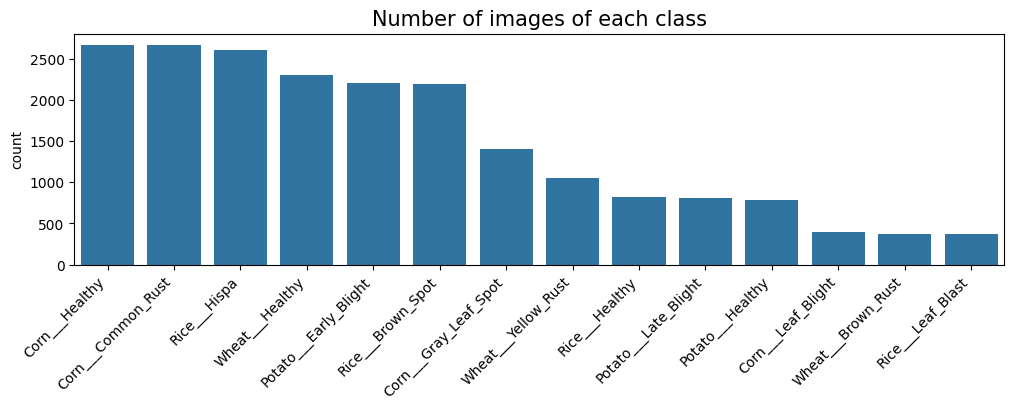

In [9]:
# visualize the class label and number of images
plt.figure(figsize=(12,3))
sns.barplot(  x = class_label, y = label_count)
plt.title("Number of images of each class", fontsize = 15)
plt.xticks(rotation=45, ha='right')
plt.show()

Corn___Healthy


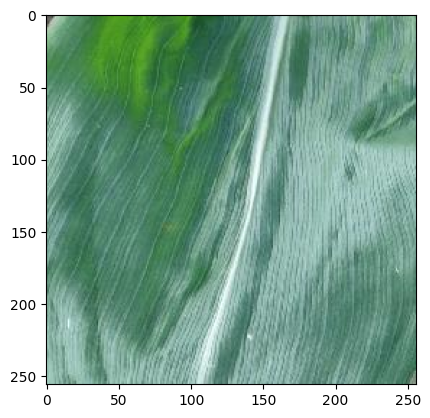

Corn___Common_Rust


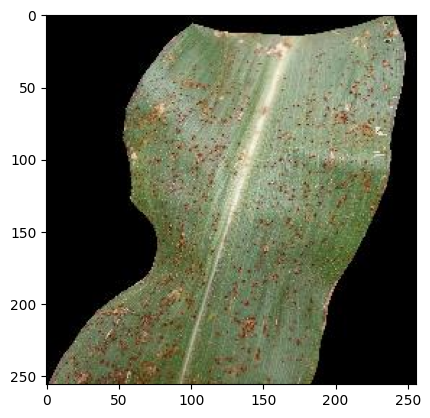

Rice___Hispa


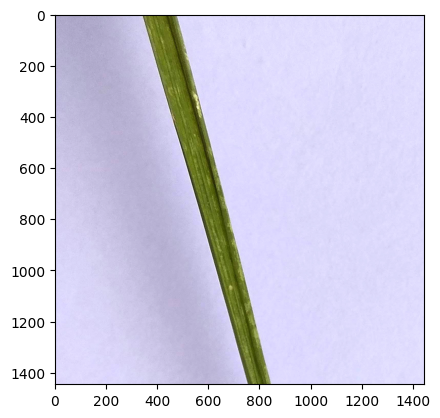

Wheat___Healthy


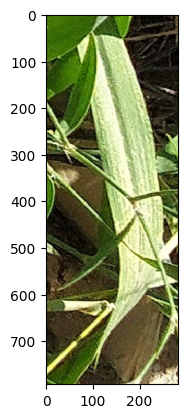

Potato___Early_Blight


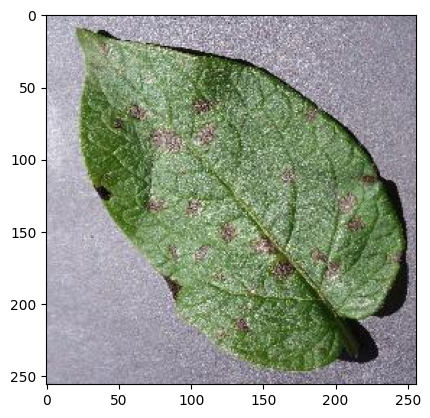

Rice___Brown_Spot


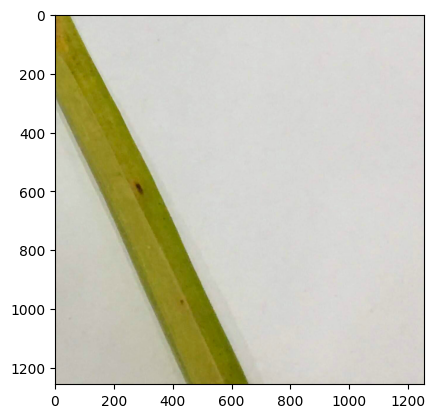

Corn___Gray_Leaf_Spot


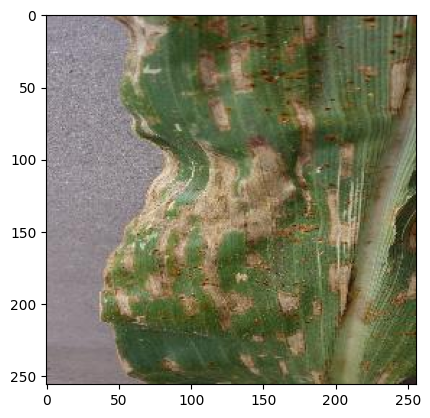

Wheat___Yellow_Rust


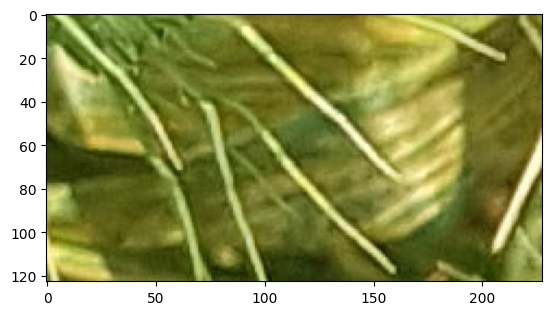

Rice___Healthy


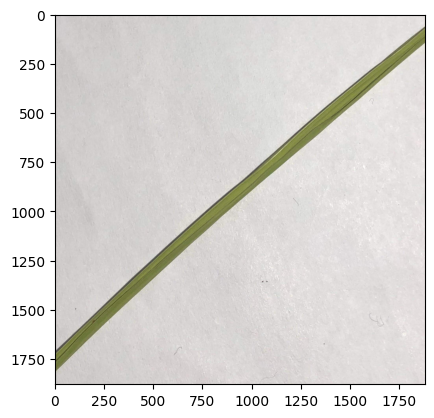

Potato___Late_Blight


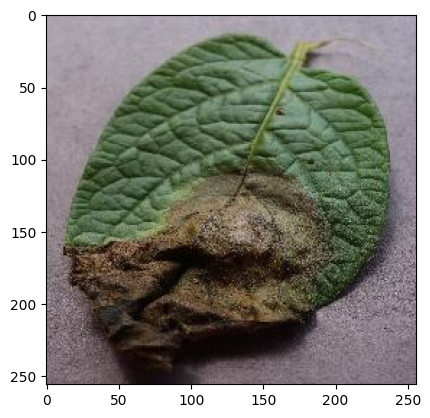

Potato___Healthy


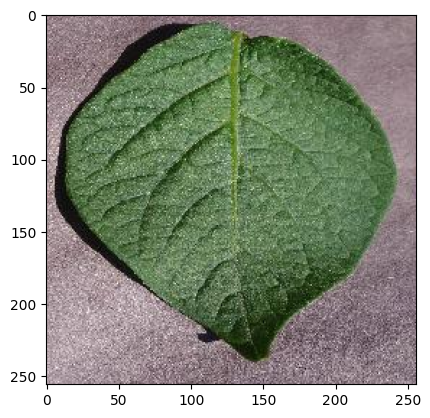

Corn___Leaf_Blight


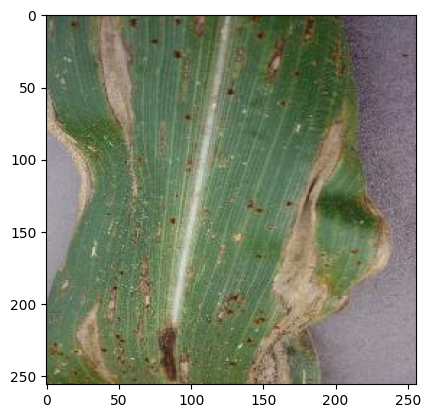

Wheat___Brown_Rust


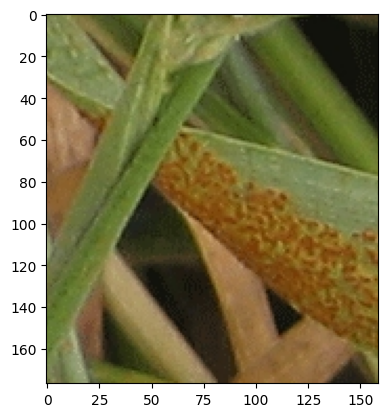

Rice___Leaf_Blast


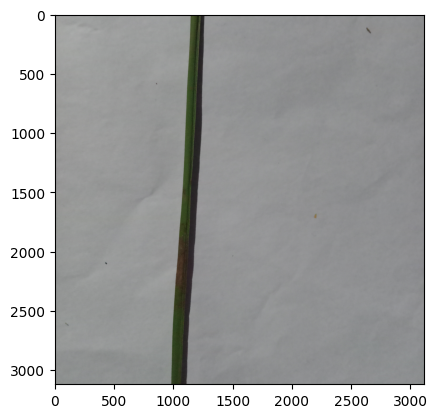

In [10]:
# covert the image to pixel
for folder in os.listdir(train_img_path):
    sub_path = train_img_path + "/" + folder

    print(folder)
    for i in range(1):
        temp_path = os.listdir(sub_path)[i]
        temp_path = sub_path + "/" + temp_path
        img = mpimg.imread(temp_path)
        imgplot = plt.imshow(img)
        plt.show()

# Data Preprocessing





In [11]:
# re-size all the images to this
IMAGE_SIZE = 224
BATCH_SIZE = 32

In [12]:
# Data augmentation for training data

train_img_datagenerator = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_img_datagenerator = ImageDataGenerator(rescale = 1./255)

training_set = train_img_datagenerator.flow_from_directory(train_img_path,
                                                 target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical')

test_set = test_img_datagenerator.flow_from_directory(test_img_path,
                                            target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'categorical')

valid_set = test_img_datagenerator.flow_from_directory(
        val_img_path,
        target_size = (IMAGE_SIZE, IMAGE_SIZE),
        batch_size = BATCH_SIZE,
        class_mode = 'categorical')

Found 20637 images belonging to 14 classes.
Found 2962 images belonging to 14 classes.
Found 5891 images belonging to 14 classes.


In [13]:
class_indices = training_set.class_indices

# Sort the class indices by their values
sorted_class_indices = sorted(class_indices.items(), key=lambda pair: pair[1])

# Extract the class names from the sorted class indices
class_names = np.array([key.title() for key, value in sorted_class_indices])

# Display the class names
print(class_names)

['Corn___Common_Rust' 'Corn___Gray_Leaf_Spot' 'Corn___Healthy'
 'Corn___Leaf_Blight' 'Potato___Early_Blight' 'Potato___Healthy'
 'Potato___Late_Blight' 'Rice___Brown_Spot' 'Rice___Healthy'
 'Rice___Hispa' 'Rice___Leaf_Blast' 'Wheat___Brown_Rust' 'Wheat___Healthy'
 'Wheat___Yellow_Rust']


## Build the Model

In [14]:
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout


In [15]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)

In [16]:
mobilenet_v2_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
mobilenet_v2_model.trainable = False



9406464/9406464 [==============================] - 1s 0us/step


In [17]:
#mobilenet_v2_model.summary()

In [18]:
# Create a new Sequential model
model = Sequential()

# Add the MobileNetV2 base model to the Sequential model
model.add(mobilenet_v2_model)

# Add a GlobalAveragePooling2D layer
model.add(GlobalAveragePooling2D())

# Add a Dense layer with 1024 units and ReLU activation
model.add(Dense(1024, activation='relu'))

# Add a Dense output layer with softmax activation for the number of classes
model.add(Dense(len(class_names), activation='softmax', name='MobileNetV2'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 MobileNetV2 (Dense)         (None, 14)                14350     
                                                                 
Total params: 3584078 (13.67 MB)
Trainable params: 1326094 (5.06 MB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [19]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=6, min_lr=1e-7)

In [20]:
# Train the model
history = model.fit(
    training_set,
    steps_per_epoch=len(training_set),
    epochs=15,
    validation_data=valid_set,
    validation_steps=len(valid_set),


)

Epoch 1/15
645/645 [==============================] - 481s 725ms/step - loss: 0.2844 - accuracy: 0.8967 - val_loss: 0.2023 - val_accuracy: 0.9241
Epoch 2/15
645/645 [==============================] - 470s 729ms/step - loss: 0.1762 - accuracy: 0.9298 - val_loss: 0.1418 - val_accuracy: 0.9423
Epoch 3/15
645/645 [==============================] - 453s 703ms/step - loss: 0.1585 - accuracy: 0.9357 - val_loss: 0.1736 - val_accuracy: 0.9302
Epoch 4/15
645/645 [==============================] - 433s 670ms/step - loss: 0.1440 - accuracy: 0.9426 - val_loss: 0.2002 - val_accuracy: 0.9294
Epoch 5/15
645/645 [==============================] - 436s 675ms/step - loss: 0.1376 - accuracy: 0.9433 - val_loss: 0.1576 - val_accuracy: 0.9362
Epoch 6/15
645/645 [==============================] - 434s 673ms/step - loss: 0.1188 - accuracy: 0.9527 - val_loss: 0.1342 - val_accuracy: 0.9470
Epoch 7/15
645/645 [==============================] - 424s 658ms/step - loss: 0.1162 - accuracy: 0.9515 - val_loss: 0.1238 -

### Training Accuracy vs Validation Graph

In [21]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

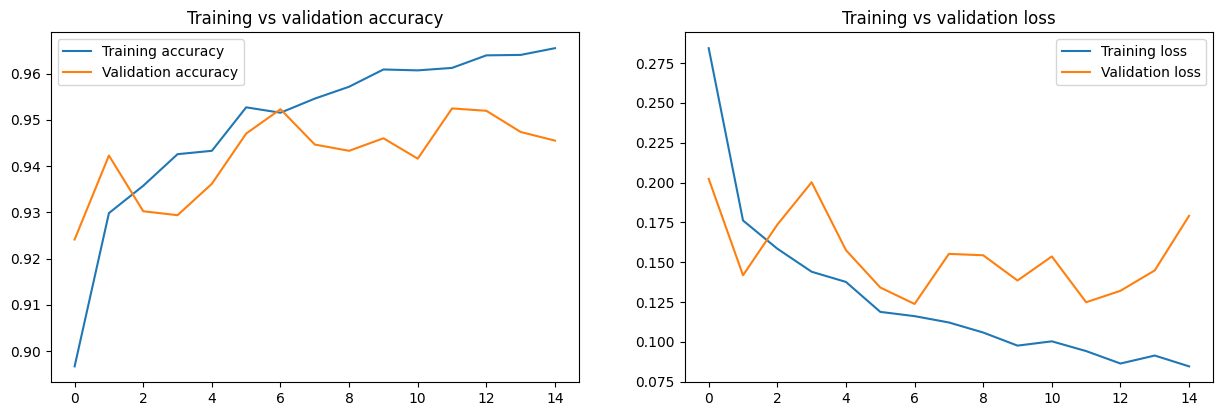

In [22]:
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()

### Evaluate the Model

In [23]:
test_loss, test_acc = model.evaluate(test_set, steps=len(test_set))
print('\nTest accuracy:', test_acc)

93/93 [==============================] - 33s 348ms/step - loss: 0.1791 - accuracy: 0.9500

Test accuracy: 0.9500337839126587


In [24]:

model.save(r"/content/drive/MyDrive/mobilenetv2_model.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Confusion Matrix


93/93 [==============================] - 28s 292ms/step
Confusion Matrix


<Axes: >

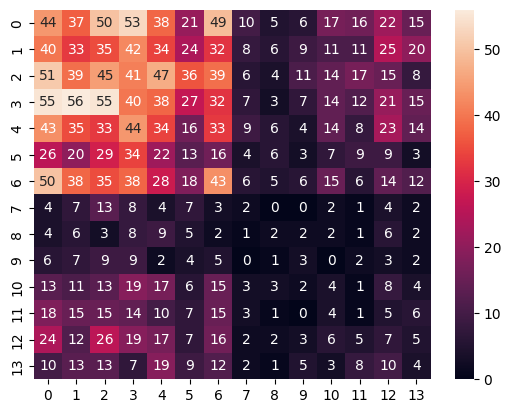

In [25]:
pred_y = model.predict(test_set)
y_pred = np.argmax(pred_y, axis=1)
cm = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
sns.heatmap(cm,annot=True)


### Make Prediction On Different Test Image

In [26]:
# Load the test image
test_img_path = r"/content/Crop_Disease/test/Wheat___Yellow_Rust/Yellow_rust014.jpg"


In [27]:
# Preprocess the test image
test_img = tf.keras.preprocessing.image.load_img(test_img_path, target_size=(224, 224))
test_img_array = tf.keras.preprocessing.image.img_to_array(test_img)
test_img_array = np.expand_dims(test_img_array, axis=0)
test_img_array = test_img_array / 255.0

In [28]:
# Make predictions
pred = model.predict(test_img_array, verbose=0)
pred_index = np.argmax(pred)
predict_class_label = class_names[pred_index]

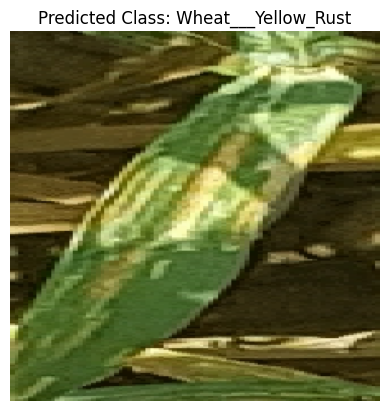

In [29]:
# Display the test image and predicted class label
plt.imshow(test_img)
plt.title(f"Predicted Class: {predict_class_label}")
plt.axis('off')
plt.show()